In [1]:
from TemperatureTimeCourse import TemperatureTimeCourse

In [2]:
from datetime import date, time, datetime, timedelta
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
def yesterday() -> datetime.date:
    return date.today()-timedelta(days=1)

In [5]:
station13777 = TemperatureTimeCourse()

In [6]:
print(f'{station13777.calc_day_mean_temperature(yesterday()):5.2f} °C')

-7.71 °C


In [7]:
xls_fn : str = './Ablesung-Gas.xlsx'
df = pd.read_excel(xls_fn, sheet_name='Sheet1', engine='openpyxl', dtype='string')

In [8]:
faktor_kwh_per_m3 = 9.82
warmwasser_energy_per_day = 0.60 * faktor_kwh_per_m3
data = {'t0':[], 't1':[], 'dt':[], 'zählerstand0':[], 'zählerstand1':[], 'verbrauch':[], 'temperatur':[], 'energy_per_day':[]}
for i in range(1,len(df)):
    if pd.notna(df.iloc[i]['Bemerkung']):
        print(f'Skip: i={i}, Bemerkung={df.iloc[i]["Bemerkung"]}')
    else:
        t0 = datetime.strptime(df.iloc[i-1]["Ablesezeitpunkt"], "%Y-%m-%d %H:%M:%S")
        t1 = datetime.strptime(df.iloc[i]["Ablesezeitpunkt"], "%Y-%m-%d %H:%M:%S")
        z0 = float(df.iloc[i-1]["Zählerstand"])
        z1 = float(df.iloc[i]["Zählerstand"])
        dt : timedelta = t1-t0
        temperature = station13777.calc_mean_temperature(t0, t1)
        energieverbrauch_per_day = (z1-z0) * faktor_kwh_per_m3 * 86400 / dt.total_seconds() - warmwasser_energy_per_day
        data['t0'].append(t0)
        data['t1'].append(t1)
        data['dt'].append(dt.total_seconds()/86400)
        data['zählerstand0'].append(z0)
        data['zählerstand1'].append(z1)
        data['verbrauch'].append(z1-z0)
        data['temperatur'].append(temperature)
        data['energy_per_day'].append(energieverbrauch_per_day)
dfout = pd.DataFrame(data)

Skip: i=28, Bemerkung=DK 2022
Skip: i=29, Bemerkung=DK 2022
Skip: i=54, Bemerkung=Zwischenablesung
Skip: i=55, Bemerkung=Zwischenablesung
Skip: i=133, Bemerkung=TÜ 2023
Skip: i=134, Bemerkung=TÜ 2023
Skip: i=135, Bemerkung=TÜ 2023


In [9]:
st = dfout['temperatur'].sum()
sy = dfout['energy_per_day'].sum()
stt = (dfout['temperatur']*dfout['temperatur']).sum()
sty = (dfout['temperatur']*dfout['energy_per_day']).sum()
n = len(dfout)

In [10]:
[a,b]=np.linalg.solve([[stt,st],[st,n]], [sty, sy])
[a,b]

[-2.908370063523458, 49.74131709034769]

In [11]:
t = dfout['temperatur']
y = dfout['energy_per_day']
y_mean = y.mean()
ssr = ((y - (a*t+b))**2).sum()
sst = ((y - y_mean)**2).sum()
R2 = 1 - (ssr/sst)
R2

0.8519865141529006

Text(0.5, 1.0, 'Gasverbrauch korreliert zu Aussentemperatur\nZeitraum: 2022-09-22 17:30:00 bis 2023-05-31 19:22:00')

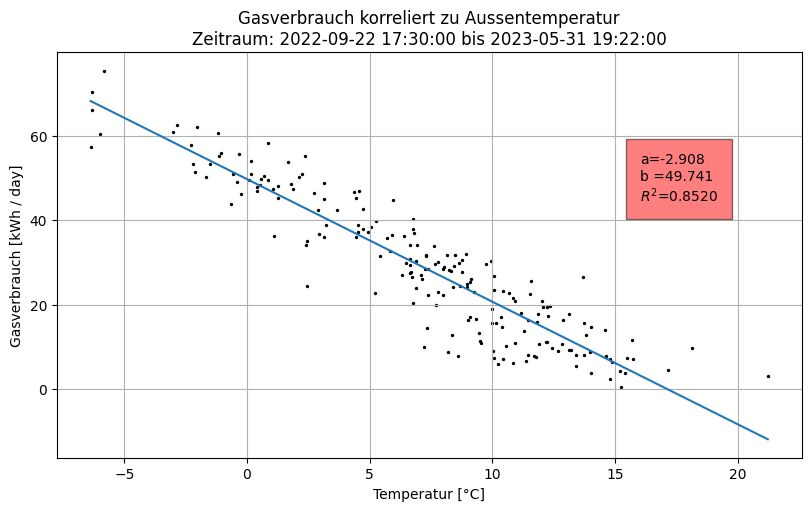

In [12]:
x = np.linspace(dfout['temperatur'].min(),dfout['temperatur'].max(), num=2)
fig, ax = plt.subplots(figsize=(8,5), layout='constrained')
ax.scatter('temperatur','energy_per_day', s=2, c='black', data=dfout)
ax.plot(x, a*x+b)
ax.set_xlabel('Temperatur [°C]')
ax.set_ylabel('Gasverbrauch [kWh / day]')
ax.grid(True)
ax.text(16, 56, f'a={a:.3f}\nb ={b:6.3f}\n$R^2$={R2:.4f}', verticalalignment='top',bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.title(f'Gasverbrauch korreliert zu Aussentemperatur\nZeitraum: {dfout.iloc[0]["t0"]} bis {dfout.iloc[-1]["t1"]}')

In [13]:
dfout.iloc[0]['t0']

Timestamp('2022-09-22 17:30:00')

In [14]:
dfout['expected_energy_per_day'] = dfout.apply(lambda row: (a * row['temperatur'] + b), axis=1)
dfout['deviation'] = dfout.apply(lambda row: row['energy_per_day'] - row['expected_energy_per_day'], axis=1)
dfout['deviation_squared'] = dfout.apply(lambda row: row['deviation'] ** 2, axis=1)